In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/name-data/names/Vietnamese.txt
/kaggle/input/name-data/names/Greek.txt
/kaggle/input/name-data/names/Japanese.txt
/kaggle/input/name-data/names/Dutch.txt
/kaggle/input/name-data/names/Irish.txt
/kaggle/input/name-data/names/Russian.txt
/kaggle/input/name-data/names/Korean.txt
/kaggle/input/name-data/names/Scottish.txt
/kaggle/input/name-data/names/Czech.txt
/kaggle/input/name-data/names/Italian.txt
/kaggle/input/name-data/names/Arabic.txt
/kaggle/input/name-data/names/Portuguese.txt
/kaggle/input/name-data/names/Spanish.txt
/kaggle/input/name-data/names/Chinese.txt
/kaggle/input/name-data/names/French.txt
/kaggle/input/name-data/names/English.txt
/kaggle/input/name-data/names/German.txt
/kaggle/input/name-data/names/Polish.txt


In [18]:
!pip install torch

In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import io
import random
import string
import glob
import unicodedata

In [20]:
ALL_letters=string.ascii_letters+" .,;'"
N_letters=len(ALL_letters)

In [21]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c)!='Mn'
        and c in ALL_letters
    )

In [22]:
def load_data():
    category_lines={}
    all_categories=[]

    def find_files(path):
        return glob.glob(path)
    
    def read_lines(filename):
        lines=io.open(filename,encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('/kaggle/input/name-data/names/*.txt'):
        category=os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        lines=read_lines(filename)
        category_lines[category]=lines

    return category_lines,all_categories

In [23]:
def letter_to_index(letter):
    return ALL_letters.find(letter)

def letter_to_tensor(letter):
    tensor=torch.zeros(1,N_letters)
    tensor[0][letter_to_index(letter)]=1
    return tensor

def line_to_tensor(line):
    tensor=torch.zeros(len(line),1,N_letters)
    for i,letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)]=1
    return tensor


In [24]:
import random
def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        # Choose an element from a list randomly
        r = random.randint(0, len(a) - 1)
        return a[r]

    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor



In [25]:
print(ALL_letters)
print(unicode_to_ascii('Ślusàrski'))
category_line ,all_categories=load_data()
print(letter_to_index('J'))
print(line_to_tensor('Jones').size())

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski
35
torch.Size([5, 1, 57])


`NOW RNN MODEL Starts Here`

In [26]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        self.hidden_size=hidden_size
        self.i2h=nn.Linear(input_size+hidden_size,hidden_size)
        self.i2o=nn.Linear(input_size+hidden_size,output_size)
        self.softmax=nn.LogSoftmax(dim=1)

    def forward(self,input_tensor,hidden_tensor):
        combinded=torch.cat((input_tensor,hidden_tensor),1)
        hidden=self.i2h(combinded)
        output=self.i2o(combinded)
        output=self.softmax(output)

        return output,hidden
    
    def init_hidden(self):
        return torch.zeros(1,self.hidden_size)

In [27]:
category_lines,all_categories=load_data()
n_categories=len(all_categories)
n_hidden=256

rnn=RNN(N_letters,n_hidden,n_categories)
input_tensor=letter_to_tensor('A')
hidden_tensor=rnn.init_hidden()
output,next_hidden=rnn(input_tensor,hidden_tensor)
input_tensor=line_to_tensor('ALbert')
hidden_tensor=rnn.init_hidden()
output,next_hidden=rnn(input_tensor[0],hidden_tensor)


In [28]:
def category_from_output(output):
    category_idx=torch.argmax(output).item()
    return all_categories[category_idx]



In [29]:
criterion=nn.NLLLoss()
learning_rate=0.005
optimizer=torch.optim.SGD(rnn.parameters(),lr=learning_rate)


5000 499900.001 2.0379 Hiu / Korean Wrong (Chinese)
10000 999900.0009999999 1.7468 Dounias / Greek Correct
15000 1499900.001 1.9037 Ganim / Arabic Correct
20000 1999900.001 1.5349 O'Gorman / Irish Correct
25000 2499900.001 2.1687 Duarte / Italian Wrong (Spanish)
30000 2999900.001 0.0061 Sokolowski / Polish Correct
35000 3499900.001 1.5367 Tse / Vietnamese Wrong (Chinese)
40000 3999900.001 1.7801 Mai / Chinese Wrong (Vietnamese)
45000 4499900.001 0.1800 Spyridis / Greek Correct
50000 4999900.001 0.9584 Chu / Vietnamese Correct
55000 5499900.001 1.7196 Franzese / French Wrong (Italian)
60000 5999900.001 0.7834 Jang / Korean Correct
65000 6499900.001 0.7143 Wen / Chinese Correct
70000 6999900.001 1.4784 Stanek / Czech Wrong (Polish)
75000 7499900.001 2.1408 Enns / English Wrong (German)
80000 7999900.001 0.1609 Michalaras / Greek Correct
85000 8499900.001 1.3944 Waltz / German Correct
90000 8999900.001 0.2576 Gorbenko / Russian Correct
95000 9499900.001 2.1507 Aita / Japanese Wrong (Itali

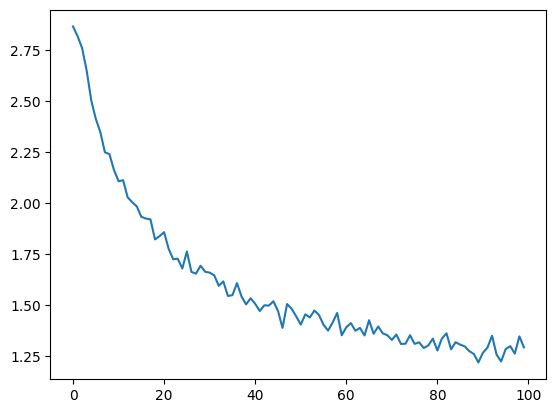

In [30]:
def train(line_tensor,category_tensor):
    hidden=rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output,hidden=rnn(line_tensor[i],hidden)

    loss=criterion(output,category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output,loss.item()

current_loss=0
all_losses=[]
plot_steps,print_steps=1000,5000
n_iters=100000
for i in range(n_iters):
    category,line,category_tensor,line_tensor=random_training_example(category_line,all_categories)
    output,loss=train(line_tensor,category_tensor)
    current_loss+=loss

    if (i+1)% plot_steps==0:
        all_losses.append(current_loss/plot_steps)
        current_loss=0
    if (i+1)% print_steps==0:
        guess=category_from_output(output)
        correct="Correct" if guess==category else f"Wrong ({category})"
        print(f'{i+1} {(i+1/n_iters)*100} {loss:.4f} {line} / {guess} {correct}')

        
plt.figure()
plt.plot(all_losses)
plt.show()
       

In [ ]:
def predit(input_line):
    print(f"\n>{input_line}")
    with torch.no_grad():
        line_tensor=line_to_tensor(input_line)
        hidden=rnn.init_hidden()
        for i in range(line_tensor.size()[0]):
            output,hidden=rnn(line_tensor[i],hidden)
        
        guess=category_from_output(output)
        print(guess)

while True:
    sentence=input("Input:")
    if sentence =="quit":
        break
    predit(sentence)
    

Input: Auttenberg



>Auttenberg
German


Input: Abatantuono



>Abatantuono
Italian


Input: Aalsburg



>Aalsburg
French


Input: Bartosz



>Bartosz
Spanish


Input: Wilson



>Wilson
Scottish


Input: Aston



>Aston
English
